In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/nba_valuation_with_star_flag.csv")

In [13]:
# add EventLabel row
df['EventLabel'] = df.apply(
    lambda row: f"{row['Team']}_{int(row['Year'])}" if row['StarArrival'] == 1 else '', axis=1)

c:\Users\shoku\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\shoku\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\shoku\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\shoku\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length

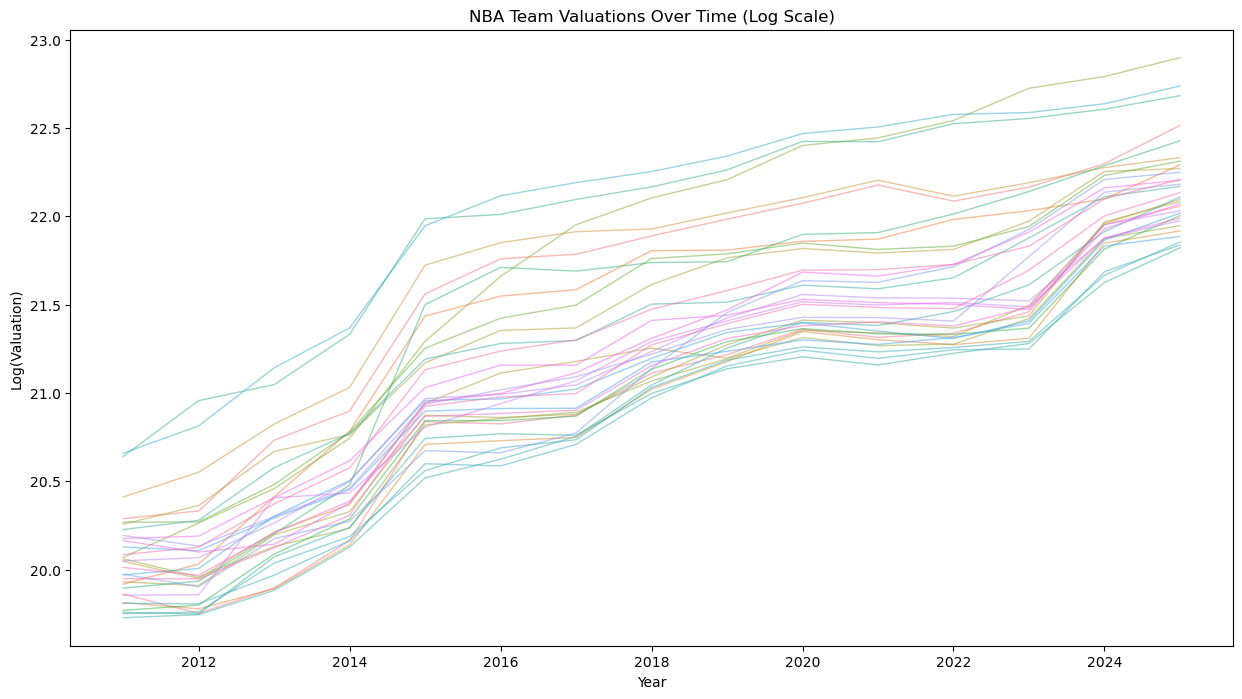

In [14]:
# log valuation line plot

plt.figure(figsize=(15, 8))
sns.lineplot(data=df, x="Year", y="LogValuation", hue="Team", linewidth=1, alpha=0.5)
plt.title("NBA Team Valuations Over Time (Log Scale)")
plt.ylabel("Log(Valuation)")
plt.legend([],[], frameon=False)  # 凡例なし


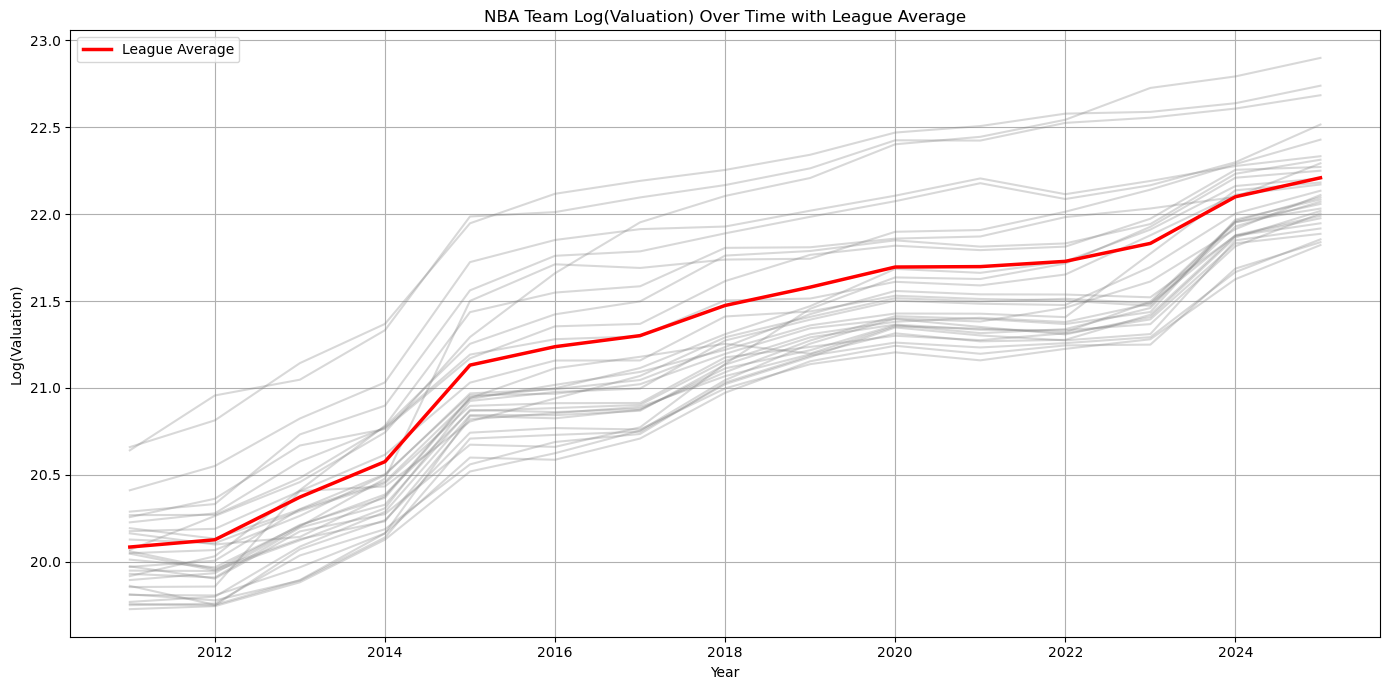

In [16]:
# log valuation line plot with league average

plt.figure(figsize=(14, 7))

# チームごとの log(Valuation)
for team, group in df[df["Team"] != "LeagueAverage"].groupby("Team"):
    plt.plot(group["Year"], group["LogValuation"], color='gray', alpha=0.3)

# リーグ平均の log(Valuation)
league_avg = df[df["Team"] == "LeagueAverage"]
plt.plot(league_avg["Year"], league_avg["LogValuation"], color='red', linewidth=2.5, label="League Average")

plt.title("NBA Team Log(Valuation) Over Time with League Average")
plt.xlabel("Year")
plt.ylabel("Log(Valuation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

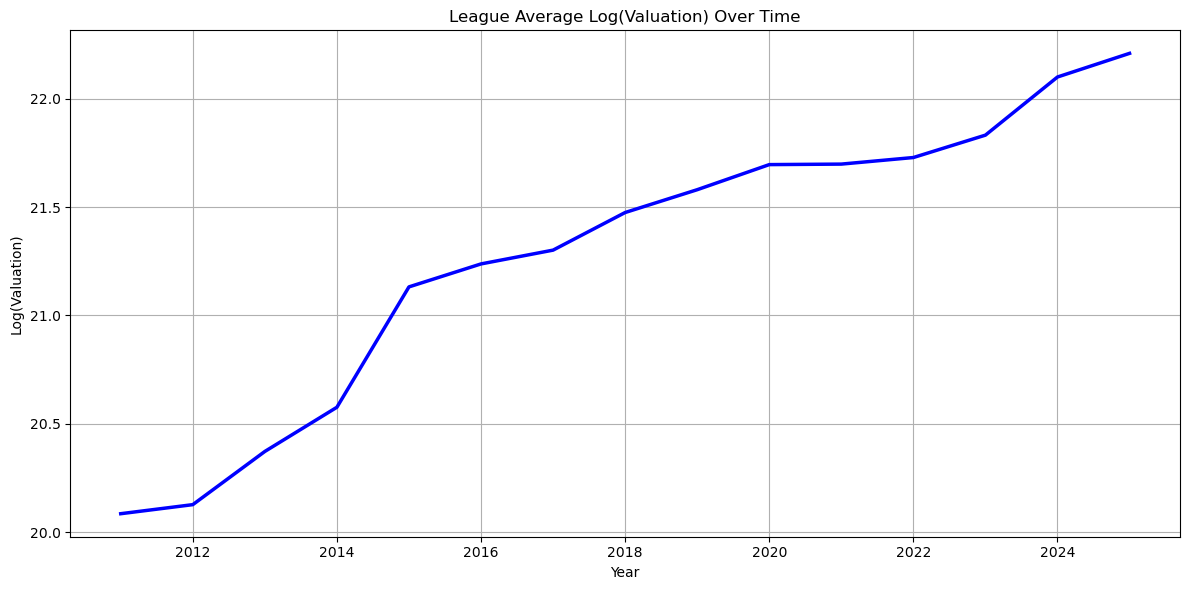

In [17]:
# log valuation line plot (league average)

plt.figure(figsize=(12, 6))
plt.plot(league_avg["Year"], league_avg["LogValuation"], color='blue', linewidth=2.5)
plt.title("League Average Log(Valuation) Over Time")
plt.xlabel("Year")
plt.ylabel("Log(Valuation)")
plt.grid(True)
plt.tight_layout()
plt.show()

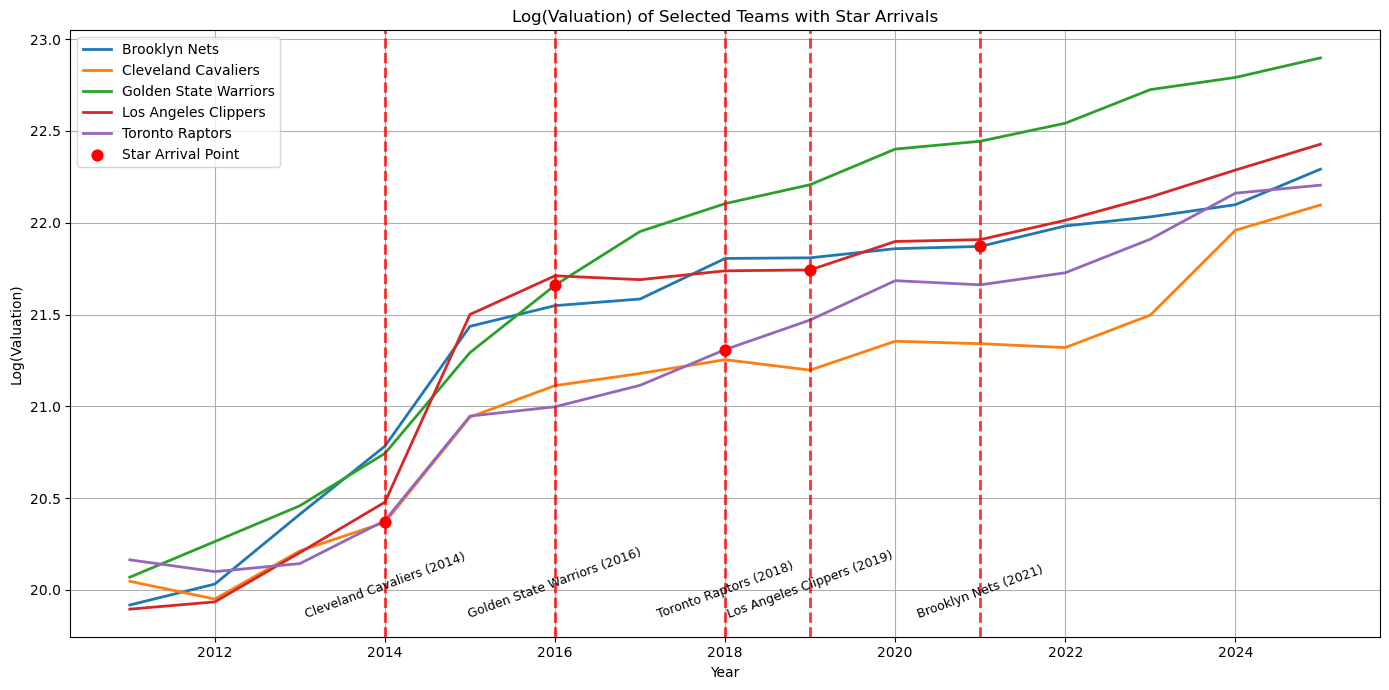

In [35]:
highlight_teams = ["Cleveland Cavaliers", "Golden State Warriors", "Toronto Raptors", "Los Angeles Clippers", "Brooklyn Nets"]
highlight_df = df[df["Team"].isin(highlight_teams)]

plt.figure(figsize=(14, 7))

for team, group in highlight_df.groupby("Team"):
    plt.plot(group["Year"], group["LogValuation"], label=team, linewidth=2)

for _, row in highlight_df[highlight_df["StarArrival"] == 1].iterrows():
    plt.axvline(x=int(row["Year"]), color='red', linestyle='--', alpha=0.8, linewidth=2)
    plt.annotate(f"{row['Team']} ({row['Year']})", 
                 xy=(row["Year"], plt.ylim()[0]),
                 xytext=(row["Year"], plt.ylim()[0] + 0.1),
                 textcoords='data',
                 ha='center',
                 fontsize=9, rotation=20)

arrival_points = highlight_df[highlight_df["StarArrival"] == 1]
plt.scatter(arrival_points["Year"], arrival_points["LogValuation"], color='red', s=60, zorder=5, label="Star Arrival Point")

plt.title("Log(Valuation) of Selected Teams with Star Arrivals")
plt.xlabel("Year")
plt.ylabel("Log(Valuation)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()





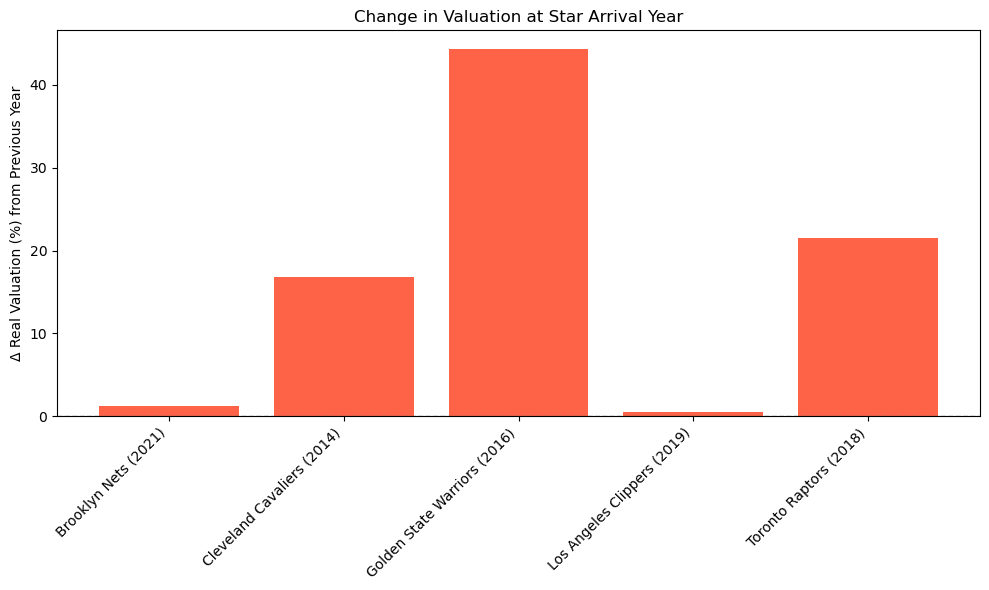

In [36]:
# ΔValuation（実質ベースの前年比）を計算
highlight_df_sorted = highlight_df.sort_values(by=["Team", "Year"])
highlight_df_sorted["ΔRealValuationPct"] = (
    highlight_df_sorted.groupby("Team")["RealValuation"].pct_change() * 100
)

# スター移籍年のみ抽出
event_df = highlight_df_sorted[highlight_df_sorted["StarArrival"] == 1].copy()

# 描画：棒グラフ（移籍年 vs ΔValuation[%]）
plt.figure(figsize=(10, 6))
bars = plt.bar(
    x=event_df["Team"] + " (" + event_df["Year"].astype(str) + ")",
    height=event_df["ΔRealValuationPct"],
    color="tomato"
)

# 軸ラベル・タイトルなど
plt.xticks(rotation=45, ha='right')
plt.ylabel("Δ Real Valuation (%) from Previous Year")
plt.title("Change in Valuation at Star Arrival Year")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()


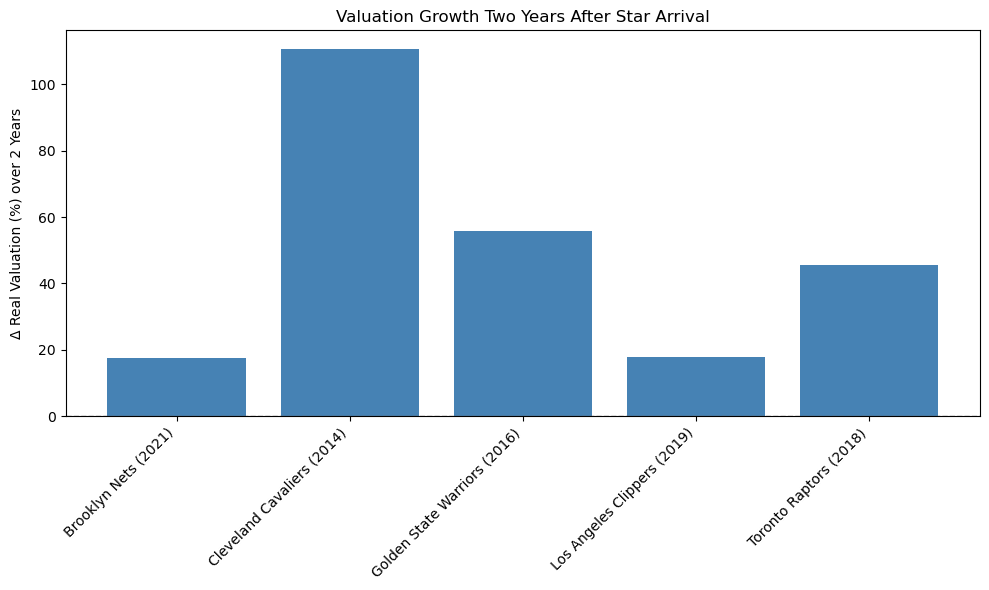

In [37]:
# 各行に対して「2年後のRealValuation」との比較を出す
# 同一チーム・Yearが (Y+2) のデータとマージ
future_df = highlight_df_sorted.copy()
future_df["Year"] = future_df["Year"] - 2  # 今の年に対して2年後の値を持ってくるため

# 現在の行に未来のRealValuationを結合
merged = pd.merge(
    highlight_df_sorted,
    future_df[["Team", "Year", "RealValuation"]],
    on=["Team", "Year"],
    how="left",
    suffixes=("", "_2YLater")
)

# 2年後との比較（%）
merged["ΔRealValuationPct_2Y"] = (
    (merged["RealValuation_2YLater"] - merged["RealValuation"]) / merged["RealValuation"] * 100
)

# スター移籍年だけ取り出す
event_df_2y = merged[merged["StarArrival"] == 1].copy()

# 棒グラフで描画
plt.figure(figsize=(10, 6))
plt.bar(
    x=event_df_2y["Team"] + " (" + event_df_2y["Year"].astype(str) + ")",
    height=event_df_2y["ΔRealValuationPct_2Y"],
    color="steelblue"
)

plt.xticks(rotation=45, ha='right')
plt.ylabel("Δ Real Valuation (%) over 2 Years")
plt.title("Valuation Growth Two Years After Star Arrival")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()
